In [119]:
#!/usr/bin/env python3 -u
# Copyright (c) 2017-present, Facebook, Inc.
# All rights reserved.
#
# This source code is licensed under the license found in the LICENSE file in
# the root directory of this source tree.
from __future__ import print_function

import argparse
import csv
import os

import numpy as np
import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import models
from utils import progress_bar
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
import MixingFunctions
import sys
import importlib  

function = importlib.import_module("Mixing-Augmentation.filters.attention.function")
attribution_methods = importlib.import_module("Mixing-Augmentation.filters.attention.filter_code.code.saliency.attribution_methods")
models_attention = importlib.import_module("Mixing-Augmentation.filters.attention.filter_code.code.models_attention")
filter_env = importlib.import_module("Mixing-Augmentation.filters.Environment.environment_apply")

importlib.reload(function)
importlib.reload(attribution_methods)
importlib.reload(models)
importlib.reload(filter_env)
# importlib.reload(MixingFunctions)


params = {
    "lr": .01,
    "resume": False,
    "model": "ResNet18",
    "name": "Attention-NoMix-NoAdvs",
    "seed": 10,
    "batch_size": 128,
    "decay": 5e-4, 
    "augment": True,
    "epoch": 200,
#     "no_augment": False,
    "alpha": 1.,
}

# %cd ../../

In [115]:
%config Completer.use_jedi = False


# checkpoint = torch.load('./checkpoint/ckpt.t7' + params["name"] + '_'
#                             + str(params["seed"]), map_location='cpu')

# net_VerticalMix_2Sets_SampEps_32_10 = checkpoint['net']
# net_VerticalMix_2Sets_SampEps_32_10.cuda()

/home/m25dehgh/testing_codes/NNs


# Loading Data

In [96]:



use_cuda = torch.cuda.is_available()

best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

if params["seed"] != 0:
    torch.manual_seed(params["seed"])

# Data
print('==> Preparing data..')
if params["augment"]:
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])
else:
    print("no augmentation")
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2023, 0.1994, 0.2010)),
    ])


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = datasets.CIFAR10(root='/home/m25dehgh/testing_codes/NNs/data', train=True, download=False,
                            transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=params["batch_size"],
                                          shuffle=True, num_workers=8)

testset = datasets.CIFAR10(root='/home/m25dehgh/testing_codes/NNs/data', train=False, download=False,
                           transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=8)

==> Preparing data..


# Creating Model 

In [97]:
# Model
if params["resume"]:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.t7' + params["name"] + '_'
                            + str(params["seed"]), map_location='cpu')
    
    net = checkpoint['net']
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch'] + 1
    rng_state = checkpoint['rng_state']
    torch.set_rng_state(rng_state)
else:
    print('==> Building model..')
    net = models.__dict__[params["model"]]()

if not os.path.isdir('results'):
    os.mkdir('results')
logname = ('results/log_' + net.__class__.__name__ + '_' + params["name"] + '_'
           + str(params["seed"]) + '.csv')

if use_cuda:
    net = torch.nn.DataParallel(net)
    net.to('cuda:0')
    print(torch.cuda.device_count())
    cudnn.benchmark = True
    print('Using CUDA..')

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=params["lr"], momentum=0.9,
                      weight_decay=params["decay"])

==> Building model..
3
Using CUDA..


# Helping functions

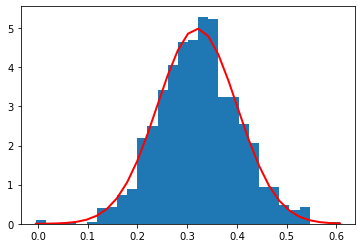

In [98]:
import matplotlib.pyplot as plt
mu, sigma = .32, .08
s = np.random.normal(mu, sigma, 1000)
# s = np.random.dirichlet(np.ones(2), 1000)[:,0]
count, bins, ignored = plt.hist(s, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ), linewidth=2, color='r')
plt.show()

In [105]:

def mixup_data(x, y, alpha=1.0, use_cuda=True, advs_train=False, epsilon=.35):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)
    

    
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    
    
    
    if advs_train:
        
        x_b = x[index, :]
        
        x_b.requires_grad_(True)
        x.requires_grad_(True)
        
        out_a = net(x)
        loss_a = criterion(out_a, y_a)
        optimizer.zero_grad()
        loss_a.backward()
        
        if type(epsilon) == tuple:
            epsilon = np.random.normal(epsilon[0], epsilon[1])
            
        
        err = torch.zeros_like(x)
        with torch.no_grad():
            err += epsilon * lam * x.grad.sign()

        out_b = net(x_b)
        loss_b = criterion(out_b, y_b)
        optimizer.zero_grad()
        loss_b.backward()
        
        with torch.no_grad():
            err += epsilon * (1 - lam) * x_b.grad.sign()
            
        mixed_x += err
        
        
        

    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def identity(x, payload=None):
    return x

def mixup_criterion_nMixes(criterion, pred, mixed_targs, wts):
    '''Returns total criterion for total mixed images'''
    
    # accumulate total criterion as weighted sum of shuffled targets, weighted with wts 
    total_criterion = 0
    for i in range(len(wts)):
        total_criterion += wts[i]*criterion(pred, mixed_targs[:,i])
    return(total_criterion)


def advs_mix_err(x, mixed_targs, mixed_indices, wts, epsilon):
    n_mix = mixed_indices.shape[0]
    noise = torch.zeros_like(x)
    
    for i in range(n_mix):
        x_batch = x[mixed_indices[i]] # ith column of mix_indices have the indices of ith batch of mixed data.
        y_batch = mixed_targs[:, i]
        
        if type(epsilon) == tuple:
            epsilon = np.random.normal(epsilon[0], epsilon[1])
        
        noise += wts[i] * fgsm(x_batch, mixed_targs[:, i], epsilon)
        
    return noise

def attention_model():
    baseAddr = './Mixing-Augmentation/filters/attention/filter_code'
    weights = torch.load(f"{baseAddr}/model.pth")
    if use_cuda:
        model = models_attention.SimpleCNN('cifar10', 'CAM').cuda()
    model.load_state_dict(weights['model'])


    CAM_cifar10 = attribution_methods.CAM(model)
    
    return CAM_cifar10
    

def train_mixup(epoch, filter_function=identity, fliter_payload=None, mixup_func=mixup_data, nMix=2, advs_train=False , epsilon=.35):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    reg_loss = 0
    correct = 0
    total = 0
    
    if type(epsilon) == tuple:
        epsilon = np.random.normal(epsilon[0], epsilon[1])
    
    
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
                 
        inputs = filter_function(inputs, payload=fliter_payload).float()
        
        mixed_x, mixed_targs, mixed_noise, wts = mixup_func(inputs, targets, nMix, net, criterion, epsilon=epsilon, advs_train=advs_train)
        mixed_targs = mixed_targs.long()
        

        if advs_train == True:
            with torch.no_grad():
                mixed_x += mixed_noise
            

        outputs = net(mixed_x)
        
        loss = mixup_criterion_nMixes(criterion, outputs, mixed_targs, wts)
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        
        for i, lam in enumerate(wts):
            correct += (lam * predicted.eq(mixed_targs[:, i].data).cpu().sum().float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        progress_bar(batch_idx, len(trainloader),
                     'Loss: %.3f | Reg: %.5f | Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), reg_loss/(batch_idx+1),
                        100.*correct/total, correct, total))
    return (train_loss/batch_idx, reg_loss/batch_idx, 100.*correct/total)



def train_normal(epochs, filter_function=identity, fliter_payload=None, advs_train=False , epsilon=.35, alpha=0.5):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    reg_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        
        inputs = filter_function(inputs, fliter_payload)
        outputs_normal = net(inputs.float())
        loss_normal = criterion(outputs_normal, targets)
        
        if advs_train:
            inputs_advs = inputs + fgsm(inputs, targets, eps=epsilon)
            outputs_advs = net(inputs_advs)
            loss_advs = criterion(outputs_advs, targets)
            loss = ((1 - alpha) * loss_advs) + (alpha * loss_normal)
        else:
            loss = loss_normal
        
        optimizer.zero_grad()
        loss.backward()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs_normal.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum().float()

        optimizer.step()

        progress_bar(batch_idx, len(trainloader),
                     'Loss: %.3f | Reg: %.5f | Acc: %.3f%% (%d/%d)'
                     % (train_loss/(batch_idx+1), reg_loss/(batch_idx+1),
                        100.*correct/total, correct, total))
        
    return (train_loss/batch_idx, reg_loss/batch_idx, 100.*correct/total)


def fgsm(x, y, eps=.35):
    
    x.requires_grad_(True)
    out = net(x)
    loss = criterion(out, y)
    optimizer.zero_grad()
    loss.backward()
        
    with torch.no_grad():
        err = eps * x.grad.sign()    

    return err

def test(epochs, filter_function=identity, fliter_payload=None,):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()

        inputs = filter_function(inputs, payload=fliter_payload).float()
        
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

        progress_bar(batch_idx, len(testloader),
                     'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                     % (test_loss/(batch_idx+1), 100.*correct/total,
                        correct, total))
    acc = 100.*correct/total
    if acc > best_acc:
        best_acc = acc
        checkpoint(acc, epoch)

        
    return (test_loss/batch_idx, 100.*correct/total)


def checkpoint(acc, epoch):
    # Save checkpoint.
    print('Saving..')
    state = {
        'net': net,
        'acc': acc,
        'epoch': epoch,
        'rng_state': torch.get_rng_state()
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/ckpt.t7' + params["name"] + '_'
               + str(params["seed"]))


def adjust_learning_rate(optimizer, epoch):
    """decrease the learning rate at 100 and 150 epoch"""
    lr = params["lr"]
    if epoch >= 100:
        lr /= 10
    if epoch >= 150:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Training the model

## loading attention model

In [100]:
model_att = attention_model()

payload={'model':model_att,'mean':(0.4914, 0.4822, 0.4465),'std':(0.2023, 0.1994, 0.2010)}

filter_env.augment_environment(x, payload={'mean':(0.4914, 0.4822, 0.4465),'std':(0.2023, 0.1994, 0.2010)})


Model Complete


In [106]:
if not os.path.exists(logname):
    with open(logname, 'w') as logfile:
        logwriter = csv.writer(logfile, delimiter=',')
        logwriter.writerow(['epoch', 'train loss', 'reg loss', 'train acc',
                            'test loss', 'test acc'])


        
        
mu = .32
sig = .08
for epoch in range(start_epoch, params["epoch"]):
    train_loss, reg_loss, train_acc = train_normal(epoch, filter_function=function.attention_mask_filter, fliter_payload=payload, advs_train=False, epsilon=(mu,sig))

    # If you are using attention please add the filter to the test data too.
    test_loss, test_acc = test(epoch, filter_function=function.attention_mask_filter, fliter_payload=payload)
    adjust_learning_rate(optimizer, epoch)
    with open(logname, 'a') as logfile:
        logwriter = csv.writer(logfile, delimiter=',')
        logwriter.writerow([epoch, train_loss, reg_loss, train_acc, test_loss,
                            test_acc])


Epoch: 52
 [=====================================================================================>]  Step: 127ms | Tot: 1m4s | Loss: 0.103 | Reg: 0.00000 | Acc: 96.366% (48183/50000 391/391 91  
 [=====================================================================================>]  Step: 90ms | Tot: 8s694ms | Loss: 0.401 | Acc: 88.410% (8841/10000 100/100 ..............................]  Step: 101ms | Tot: 2s398ms | Loss: 0.387 | Acc: 88.857% (2488/2800 28/100 ====>.................]  Step: 100ms | Tot: 7s34ms | Loss: 0.394 | Acc: 88.642% (7180/8100 81/100 ===============================================================>................]  Step: 101ms | Tot: 7s135ms | Loss: 0.393 | Acc: 88.671% (7271/8200 82/100 

Epoch: 53
 [=====================================================================================>]  Step: 117ms | Tot: 1m5s | Loss: 0.097 | Reg: 0.00000 | Acc: 96.650% (48325/50000 391/391 91  
 [=============================================================================

 [=====================================================================================>]  Step: 108ms | Tot: 1m1s | Loss: 0.080 | Reg: 0.00000 | Acc: 97.242% (48621/50000 391/391 91  
 [=====================================================================================>]  Step: 73ms | Tot: 7s521ms | Loss: 0.476 | Acc: 87.820% (8782/10000 100/100 

Epoch: 73
 [=====================================================================================>]  Step: 106ms | Tot: 1m1s | Loss: 0.085 | Reg: 0.00000 | Acc: 97.056% (48528/50000 391/391 91  
 [=====================================================================================>]  Step: 72ms | Tot: 7s522ms | Loss: 0.397 | Acc: 88.430% (8843/10000 100/100 

Epoch: 74
 [=====================================================================================>]  Step: 113ms | Tot: 1m1s | Loss: 0.086 | Reg: 0.00000 | Acc: 96.984% (48492/50000 391/391 91  
 [=====================================================================================>]

 [=====================================================================================>]  Step: 119ms | Tot: 1m5s | Loss: 0.078 | Reg: 0.00000 | Acc: 97.354% (48677/50000 391/391 91  .....................................]  Step: 197ms | Tot: 16s806ms | Loss: 0.078 | Reg: 0.00000 | Acc: 97.564% (12738/13056 102/39 185/391 
 [=====================================================================================>]  Step: 105ms | Tot: 8s427ms | Loss: 0.352 | Acc: 90.220% (9022/10000 100/100 /100 

Epoch: 92
 [=====================================================================================>]  Step: 119ms | Tot: 1m5s | Loss: 0.078 | Reg: 0.00000 | Acc: 97.312% (48656/50000 391/391 91  .......]  Step: 198ms | Tot: 10s390ms | Loss: 0.078 | Reg: 0.00000 | Acc: 97.241% (7966/8192 64/391 
 [=====================================================================================>]  Step: 87ms | Tot: 8s731ms | Loss: 0.403 | Acc: 89.230% (8923/10000 100/100 .........]  Step: 89ms | Tot: 6s408ms | 

 [=====================================================================================>]  Step: 73ms | Tot: 7s426ms | Loss: 0.270 | Acc: 92.980% (9298/10000 100/100 
Saving..

Epoch: 112
 [=====================================================================================>]  Step: 111ms | Tot: 1m93ms | Loss: 0.009 | Reg: 0.00000 | Acc: 99.762% (49881/50000 391/391 1 
 [=====================================================================================>]  Step: 73ms | Tot: 7s415ms | Loss: 0.268 | Acc: 92.830% (9283/10000 100/100 

Epoch: 113
 [=====================================================================================>]  Step: 128ms | Tot: 1m505ms | Loss: 0.009 | Reg: 0.00000 | Acc: 99.782% (49891/50000 391/391  91 
 [=====================================================================================>]  Step: 73ms | Tot: 7s459ms | Loss: 0.270 | Acc: 92.980% (9298/10000 100/100 

Epoch: 114
 [===============================================================================

 [=====================================================================================>]  Step: 123ms | Tot: 1m1s | Loss: 0.005 | Reg: 0.00000 | Acc: 99.890% (49945/50000 391/391 91  
 [=====================================================================================>]  Step: 76ms | Tot: 7s464ms | Loss: 0.274 | Acc: 93.120% (9312/10000 100/100 

Epoch: 134
 [=====================================================================================>]  Step: 112ms | Tot: 1m925ms | Loss: 0.005 | Reg: 0.00000 | Acc: 99.902% (49951/50000 391/391  
 [=====================================================================================>]  Step: 76ms | Tot: 7s398ms | Loss: 0.272 | Acc: 93.230% (9323/10000 100/100 

Epoch: 135
 [=====================================================================================>]  Step: 111ms | Tot: 1m723ms | Loss: 0.005 | Reg: 0.00000 | Acc: 99.890% (49945/50000 391/391  
 [=====================================================================================

 [=====================================================================================>]  Step: 112ms | Tot: 1m450ms | Loss: 0.004 | Reg: 0.00000 | Acc: 99.928% (49964/50000 391/391  
 [=====================================================================================>]  Step: 68ms | Tot: 7s278ms | Loss: 0.271 | Acc: 93.260% (9326/10000 100/100 

Epoch: 155
 [=====================================================================================>]  Step: 106ms | Tot: 1m242ms | Loss: 0.003 | Reg: 0.00000 | Acc: 99.950% (49975/50000 391/391  
 [=====================================================================================>]  Step: 70ms | Tot: 7s337ms | Loss: 0.271 | Acc: 93.320% (9332/10000 100/100 

Epoch: 156
 [=====================================================================================>]  Step: 109ms | Tot: 1m347ms | Loss: 0.004 | Reg: 0.00000 | Acc: 99.932% (49966/50000 391/391  
 [=====================================================================================

 [=====================================================================================>]  Step: 111ms | Tot: 1m1s | Loss: 0.003 | Reg: 0.00000 | Acc: 99.940% (49970/50000 391/391 91  
 [=====================================================================================>]  Step: 72ms | Tot: 7s536ms | Loss: 0.269 | Acc: 93.220% (9322/10000 100/100 

Epoch: 177
 [=====================================================================================>]  Step: 142ms | Tot: 1m4s | Loss: 0.003 | Reg: 0.00000 | Acc: 99.928% (49964/50000 391/391 91  330/39 341/391 
 [=====================================================================================>]  Step: 84ms | Tot: 8s888ms | Loss: 0.267 | Acc: 93.250% (9325/10000 100/100 ======>........................................]  Step: 105ms | Tot: 4s794ms | Loss: 0.281 | Acc: 92.944% (5019/5400 54/100 

Epoch: 178
 [=====================================================================================>]  Step: 136ms | Tot: 1m5s | Loss: 0.003 | Re

 [=====================================================================================>]  Step: 99ms | Tot: 8s631ms | Loss: 0.267 | Acc: 93.350% (9335/10000 100/100 ==============>......................................................]  Step: 96ms | Tot: 3s196ms | Loss: 0.282 | Acc: 92.947% (3532/3800 38/100 

Epoch: 194
 [=====================================================================================>]  Step: 110ms | Tot: 1m5s | Loss: 0.003 | Reg: 0.00000 | Acc: 99.962% (49981/50000 391/391 91  ===============================>.......................]  Step: 195ms | Tot: 47s455ms | Loss: 0.003 | Reg: 0.00000 | Acc: 99.959% (36337/36352 284/391 
 [=====================================================================================>]  Step: 78ms | Tot: 8s707ms | Loss: 0.267 | Acc: 93.330% (9333/10000 100/100 ===========>.......................................]  Step: 96ms | Tot: 4s771ms | Loss: 0.279 | Acc: 92.982% (5114/5500 55/100 77/100 78/100 

Epoch: 195
 [==================

In [ ]:
to_learn = {"name": ["EnvFilter-NoMix-NoAdvs","Attention-LinearMix-2Sets-128-AdvsTrain-Eps(.32, .08)", 
                     "EnvFilter-LinearMix-2Sets-128-AdvsTrain-Eps(.32, .08)"],
            "normal": [True, False, False],
            "attention": [False, True, False]
           }

for l_num in range(3):

    params = {
        "lr": .01,
        "resume": False,
        "model": "ResNet18",
        "name": to_learn['name'][l_num],
        "seed": 10,
        "batch_size": 128,
        "decay": 1e-4, 
        "augment": True,
        "epoch": 200,
    #     "no_augment": False,
        "alpha": 1.,
    }
    
    if to_learn['normal'][l_num]:
        params['decay'] = 5e-4

    # Model
    if params["resume"]:
        # Load checkpoint.
        print('==> Resuming from checkpoint..')
        assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
        checkpoint = torch.load('./checkpoint/ckpt.t7' + params["name"] + '_'
                                + str(params["seed"]), map_location='cpu')

        net = checkpoint['net']
        best_acc = checkpoint['acc']
        start_epoch = checkpoint['epoch'] + 1
        rng_state = checkpoint['rng_state']
        torch.set_rng_state(rng_state)
    else:
        print('==> Building model..')
        net = models.__dict__[params["model"]]()

    if not os.path.isdir('results'):
        os.mkdir('results')
    logname = ('results/log_' + net.__class__.__name__ + '_' + params["name"] + '_'
               + str(params["seed"]) + '.csv')

    if use_cuda:
        net = torch.nn.DataParallel(net)
        net.to('cuda:0')
        print(torch.cuda.device_count())
        cudnn.benchmark = True
        print('Using CUDA..')

    start_epoch = 0
    best_acc = 0

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=params["lr"], momentum=0.9,
                          weight_decay=params["decay"])

    # import importlib
    # importlib.reload(MixingFunctions)
    importlib.reload(function)
    importlib.reload(attribution_methods)
    importlib.reload(models)
    importlib.reload(filter_env)

    
    if not os.path.exists(logname):
        with open(logname, 'w') as logfile:
            logwriter = csv.writer(logfile, delimiter=',')
            logwriter.writerow(['epoch', 'train loss', 'reg loss', 'train acc',
                                'test loss', 'test acc'])

    mu = .32
    sig = .08

    for epoch in range(start_epoch, params["epoch"]):
        
        print(f"training {to_learn['name'][l_num]} model")
        
        if to_learn['normal'][l_num]:
            train_loss, reg_loss, train_acc = train_normal(epoch, filter_function=filter_env.augment_environment, fliter_payload=payload, advs_train=False, epsilon=(mu,sig))
        elif l_num == 1:
            train_loss, reg_loss, train_acc = train_mixup(epoch, filter_function=function.attention_mask_filter, fliter_payload=payload, mixup_func=MixingFunctions.mixup_data_nMixes, nMix=2, advs_train=True, epsilon=(mu,sig))
        elif l_num == 2:
            train_loss, reg_loss, train_acc = train_mixup(epoch, filter_function=filter_env.augment_environment, fliter_payload=payload, mixup_func=MixingFunctions.mixup_data_nMixes, nMix=2, advs_train=True, epsilon=(mu,sig))
            
        # If you are using attention please add the filter to the test data too.
        
        if to_learn['attention'][l_num]:
            test_loss, test_acc = test(epoch, filter_function=function.attention_mask_filter, fliter_payload=payload)
        else:
            test_loss, test_acc = test(epoch)
        adjust_learning_rate(optimizer, epoch)
        with open(logname, 'a') as logfile:
            logwriter = csv.writer(logfile, delimiter=',')
            logwriter.writerow([epoch, train_loss, reg_loss, train_acc, test_loss,
                                test_acc])

==> Building model..
3
Using CUDA..
training EnvFilter-NoMix-NoAdvs model

Epoch: 0
 [=====================================================================================>]  Step: 180ms | Tot: 1m24s | Loss: 1.801 | Reg: 0.00000 | Acc: 33.302% (16651/50000 391/391 1  .........................................]  Step: 202ms | Tot: 6s212ms | Loss: 2.245 | Reg: 0.00000 | Acc: 15.286% (587/3840 30/391 ==========================>...........................................................]  Step: 202ms | Tot: 26s470ms | Loss: 2.027 | Reg: 0.00000 | Acc: 24.047% (3786/15744 123/391 ==============>........................................................]  Step: 197ms | Tot: 28s692ms | Loss: 2.012 | Reg: 0.00000 | Acc: 24.718% (4208/17024 133/391 200/391 ==========================>..............................]  Step: 199ms | Tot: 54s933ms | Loss: 1.889 | Reg: 0.00000 | Acc: 29.666% (9683/32640 255/391 270/391 ............]  Step: 200ms | Tot: 59s424ms | Loss: 1.874 | Reg: 0.00000 | Acc: 30.211

# Robustness Evaluation

In [ ]:
def eval_robust(net, epsilon=0):

    net.to(f'cuda:{net.device_ids[0]}')
    net.eval()
    incorrect = 0
    total = 0
    
    for batch_idx, (normal_inpts, targets) in tqdm(enumerate(testloader)):
        if use_cuda:
            normal_inpts, targets = normal_inpts.cuda(), targets.cuda()
#             normal_inpts, targets = normal_inpts.to('cuda:1'), targets.to('cuda:1')
#         normal_inpts, targets = Variable(normal_inpts, volatile=True), Variable(targets)
        normal_inpts.requires_grad_(True)
        
        outputs = net(normal_inpts)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        
        
        with torch.no_grad():
            advers_inp = normal_inpts + (epsilon * normal_inpts.grad.sign())
            advers_out = net(advers_inp)
#             print(advers_out.cpu().data.shape)
            normal_out = net(normal_inpts)
            _,advs_predicted = torch.max(advers_out.data, 1)
            _,normal_predicted = torch.max(normal_out.data, 1)
    

#         _, advs_predicted = torch.max(advs_predicted.data, 1)
        total += targets.size(0)
        incorrect += targets.size(0) - advs_predicted.eq(targets.data).sum()
    
    print(f'incorrects are: {incorrect} \ntotal is: {total} \nTop-1 error is {100.*incorrect/total}')
        
    return 100.*incorrect/total
#     acc = 100.*correct/total
#     return (test_loss/batch_idx, 100.*correct/total)

In [468]:
to_acc_tensor([eval_robust(net, 0)])

100it [00:09, 10.69it/s]

incorrects are: 511 
total is: 10000 
Top-1 error is 5.109999656677246


tensor([94.8900])

In [116]:
best_acc

tensor(93.4600)

In [76]:
def robust_eval_range(net, points=15, delta=.04):
    eps_list = [i * delta for i in list(range(points))]
    top_one_errs = []
    for i in eps_list:
        top_one_errs.append(eval_robust(net, i))
    return top_one_errs, eps_list

In [133]:
def to_acc_tensor(arr):
    return 100 - torch.cat([i.reshape(1) for i in arr]).cpu()

In [581]:
# err_norm_advs, eps_list = robust_eval_range(net_norm_adv)
# err35, eps_list = robust_eval_range(net35)
# err25, eps_list = robust_eval_range(net25)
# err45, eps_list = robust_eval_range(net45)
# err_mixup, eps_list = robust_eval_range(net)
# err_erm_noadvs, eps_list = robust_eval_range(net_ERM_noadvs)
# err_SampEps_32_08, eps_list = robust_eval_range(net_SampEps_32_10)
# err05, eps_list = robust_eval_range(net)
# err_SampEpsBeta_1_1, eps_list = robust_eval_range(net)
# err_SampEps_32_08_linear_3samp, eps_list = robust_eval_range(net)
# err_NoAdvs_linear_3samp, eps_list = robust_eval_range(net)
# err_SampEps_32_08_Vertical_3samp, eps_list = robust_eval_range(net)
# err_SampEps_32_08_Vertical_2samp, eps_list = robust_eval_range(net_VerticalMix_2Sets_SampEps_32_10)
err_testing_samp, eps_list = robust_eval_range(net)

100it [00:09, 10.57it/s]

incorrects are: 1110 
total is: 10000 
Top-1 error is 11.09999942779541



100it [00:09, 10.90it/s]

incorrects are: 4263 
total is: 10000 
Top-1 error is 42.62999725341797



100it [00:09, 10.95it/s]

incorrects are: 3812 
total is: 10000 
Top-1 error is 38.119998931884766



100it [00:09, 10.83it/s]

incorrects are: 2296 
total is: 10000 
Top-1 error is 22.959999084472656



100it [00:09, 10.59it/s]

incorrects are: 1059 
total is: 10000 
Top-1 error is 10.59000015258789



100it [00:09, 10.89it/s]

incorrects are: 607 
total is: 10000 
Top-1 error is 6.069999694824219



100it [00:09, 10.90it/s]

incorrects are: 519 
total is: 10000 
Top-1 error is 5.190000057220459



100it [00:08, 11.30it/s]

incorrects are: 569 
total is: 10000 
Top-1 error is 5.690000057220459



100it [00:09, 10.81it/s]

incorrects are: 770 
total is: 10000 
Top-1 error is 7.699999809265137



100it [00:09, 10.55it/s]

incorrects are: 1088 
total is: 10000 
Top-1 error is 10.880000114440918



100it [00:09, 10.90it/s]

incorrects are: 1551 
total is: 10000 
Top-1 error is 15.50999927520752



100it [00:09, 10.82it/s]

incorrects are: 2162 
total is: 10000 
Top-1 error is 21.619998931884766



100it [00:09, 10.88it/s]

incorrects are: 2805 
total is: 10000 
Top-1 error is 28.049999237060547



100it [00:08, 11.20it/s]

incorrects are: 3545 
total is: 10000 
Top-1 error is 35.45000076293945



100it [00:09, 10.63it/s]

incorrects are: 4258 
total is: 10000 
Top-1 error is 42.57999801635742


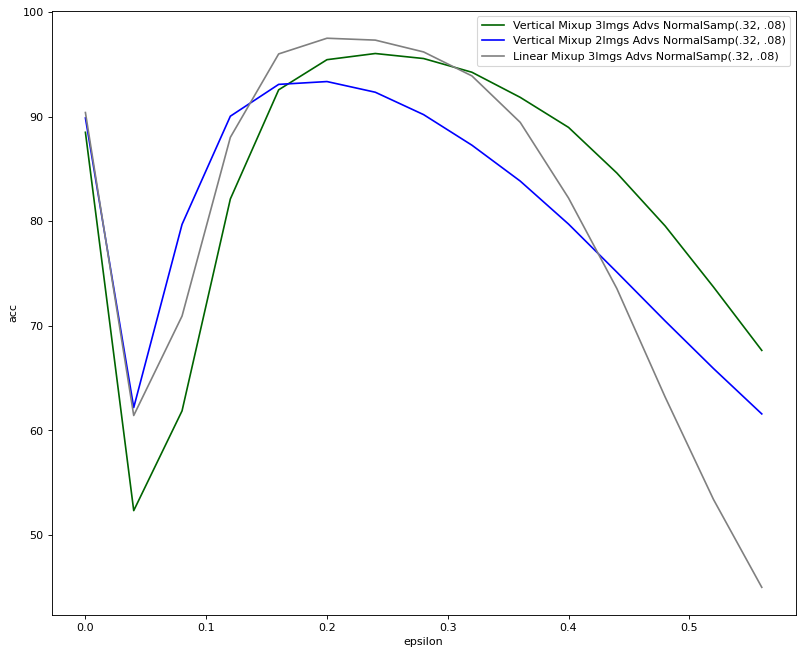

In [578]:
from matplotlib.pyplot import figure

figure(figsize=(12, 10), dpi=80)

plt.xlabel('epsilon'); plt.ylabel('acc');

plt.plot(eps_list, to_acc_tensor(err_testing_samp), c='darkgreen')
# plt.plot(eps_list, to_acc_tensor(err_SampEps_32_08_Vertical_3samp), c='black')
# plt.plot(eps_list, to_acc_tensor(err_SampEps_32_08_Vertical_2samp), c='gold')
plt.plot(eps_list, to_acc_tensor(err_SampEps_32_08_linear_3samp), c='b')
plt.plot(eps_list, to_acc_tensor(err_SampEps_32_08), c='gray')

plt.legend(['Vertical Mixup 3Imgs Advs NormalSamp(.32, .08)','Vertical Mixup 2Imgs Advs NormalSamp(.32, .08)','Linear Mixup 3Imgs Advs NormalSamp(.32, .08)', 'Mixup Advs 2Imgs NormalSamp(.32, .08)',])

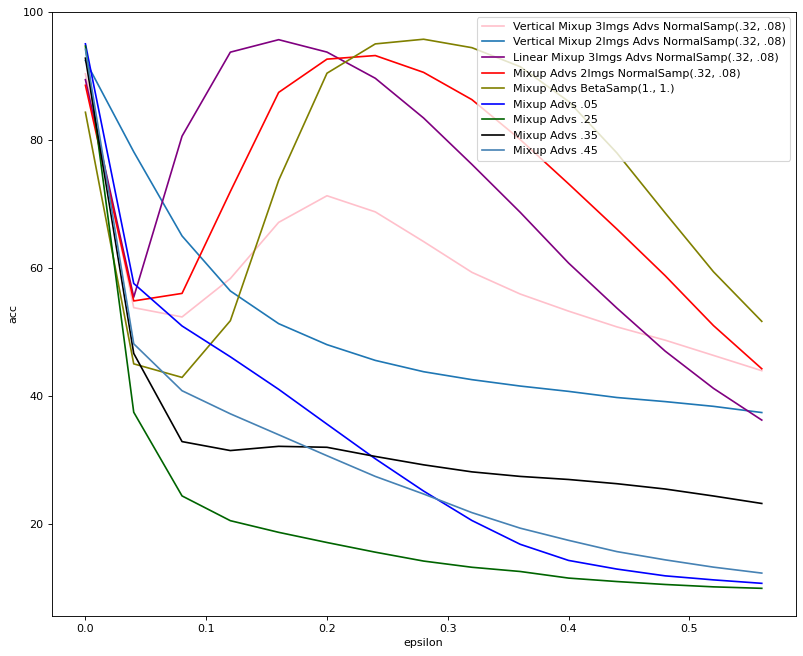

In [576]:
from matplotlib.pyplot import figure

figure(figsize=(12, 10), dpi=80)

plt.xlabel('epsilon'); plt.ylabel('acc');


# plt.plot(eps_list, to_acc_tensor(err_SampEps_32_08_Vertical_3samp), c='peru')
# plt.plot(eps_list, to_acc_tensor(err_SampEps_32_08_Vertical_2samp), c='olive')
# plt.plot(eps_list, to_acc_tensor(err_SampEps_32_08_linear_3samp), c='gold')
plt.plot(eps_list, to_acc_tensor(err_SampEps_32_08), c='gray')
plt.plot(eps_list, to_acc_tensor(err_SampEpsBeta_1_1), c='pink')
plt.plot(eps_list, to_acc_tensor(err05))
plt.plot(eps_list, to_acc_tensor(err25), c='purple')
plt.plot(eps_list, to_acc_tensor(err35), c='r')
plt.plot(eps_list, to_acc_tensor(err45), c='olive')
plt.plot(eps_list, to_acc_tensor(err_mixup), c='b')
plt.plot(eps_list, to_acc_tensor(err_erm_noadvs), c = 'darkgreen')
plt.plot(eps_list, to_acc_tensor(err_norm_advs), c='black')
plt.plot(eps_list, to_acc_tensor(err_NoAdvs_linear_3samp), c='steelblue')

plt.legend(['Vertical Mixup 3Imgs Advs NormalSamp(.32, .08)','Vertical Mixup 2Imgs Advs NormalSamp(.32, .08)','Linear Mixup 3Imgs Advs NormalSamp(.32, .08)', 'Mixup Advs 2Imgs NormalSamp(.32, .08)', 'Mixup Advs BetaSamp(1., 1.)', 'Mixup Advs .05', 'Mixup Advs .25', 'Mixup Advs .35', 'Mixup Advs .45', 'Vanilla Mixup', 'Vanilla Training', 'Normal Advs Training', 'Normal LinearMixup 3Imgs']);


In [164]:
def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.imshow(npimg)
    plt.show()

In [654]:
while './Mixing-Augmentation/filters/attention' in sys.path:
    sys.path.remove('./Mixing-Augmentation/filters/attention')
    
sys.path

['/home/m25dehgh/testing_codes/NNs/Mixing-Augmentation/Adversarially-training-mixed',
 '/home/m25dehgh/anaconda3/envs/hugging/lib/python38.zip',
 '/home/m25dehgh/anaconda3/envs/hugging/lib/python3.8',
 '/home/m25dehgh/anaconda3/envs/hugging/lib/python3.8/lib-dynload',
 '',
 '/home/m25dehgh/anaconda3/envs/hugging/lib/python3.8/site-packages',
 '/home/m25dehgh/anaconda3/envs/hugging/lib/python3.8/site-packages/IPython/extensions',
 '/home/m25dehgh/.ipython']

In [21]:
!cd $baseAddr

/bin/bash: line 0: cd: ./Mixing-Augmentation.filters.attention.filter_code: No such file or directory


In [53]:



# loading model


masked_imgs.shape

Model Complete
torch.Size([128, 3, 32, 32])
<class 'str'>


torch.Size([128, 3, 32, 32])

In [ ]:
function = importlib.import_module("Mixing-Augmentation.filters.Environment")

masked_imgs = attention_mask_filter(torch.rand(10,3,32,32), payload={'model':CAM_cifar10,'mean':(0.4914, 0.4822, 0.4465),'std':(0.2023, 0.1994, 0.2010)})

masked_imgs.shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


true labels is 1 
 adversaliral predicted is tensor([6]) 
 nomral is predictedtensor([1])


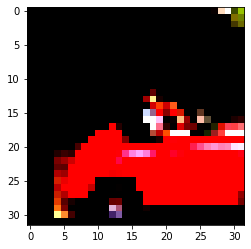

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


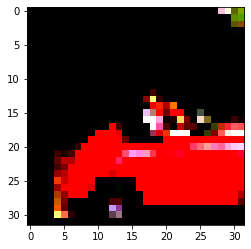

In [186]:
epsilon = .11
i = random.randint(0,100)
# i = 1


normal_inpt = trainset[i][0].reshape(1,3,32,32).cuda()
normal_inpt.requires_grad_(True)
out = net(normal_inpt)

target = torch.tensor([trainset[i][1]]).cuda()

loss = criterion(out, target)

optimizer.zero_grad()
loss.backward()

with torch.no_grad():
    advers_inp = normal_inpt + (epsilon * normal_inpt.grad.sign())
    advers_out = net(advers_inp)
    normal_out = net(normal_inpt)
    _,advs_predicted = torch.max(advers_out.cpu().data, 1)
    _,normal_predicted = torch.max(normal_out.cpu().data, 1)
    
print(f'true labels is {target.item()} \n adversaliral predicted is {advs_predicted} \n nomral is predicted{normal_predicted}')

imshow(normal_inpt.cpu().detach().squeeze())
imshow(advers_inp.cpu().detach().squeeze())

In [264]:
# advers_out = net(advers_inp) #+ (epsilon * normal_inpt.grad.sign())
# print(advers_out)
mx = 100
for j in range(1000):
    i = random.randint(0,3000)
    if torch.min(torch.min(trainset[i][0], -1)[0], -1)[0][0] < mx:
        mx = torch.min(torch.min(trainset[i][0], -1)[0], -1)[0][0]
mx

tensor(-2.4291)

In [ ]:
import pandas as pd

df = pd.read_csv("~/testing_codes/NNs/results/log_ResNet_ERM-128-WithAug_10.csv")
df